##Esse é um notebook que constroe um jogo da velha com Deep Reinforcement Learning.

###Instalação das bibliotecas faltantes do google colab

In [1]:
#!pip uninstall tensorflow -y
#!pip install tensorflow
#!pip uninstall keras -y
#!pip install keras
!pip install keras-rl2
#!pip install wandb #biblioteca de log

     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 87.9MB 64kB/s 
     |████████████████████████████████| 3.1MB 41.1MB/s 
     |████████████████████████████████| 501kB 51.4MB/s 
  Created wheel for keras-rl2: filename=keras_rl2-1.0.3-cp36-none-any.whl size=52852 sha256=56534a24533c0ce92e58411b59e2309334e87f943f30bda1af529386df69f35a
  Stored in directory: /root/.cache/pip/wheels/75/70/d7/65d0ca0a87c24f988435973065ef7ddf78af43a603a035aac0
Successfully built keras-rl2
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


###Importação das bibliotecas que serão usadas durante o código.

In [2]:
import numpy as np
import gym
from gym import spaces

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import time

from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import GreedyQPolicy, EpsGreedyQPolicy, BoltzmannQPolicy, MaxBoltzmannQPolicy, BoltzmannGumbelQPolicy
from keras.callbacks.callbacks import LambdaCallback

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

###Criação da função que define o modelo de Redes Neurais Artificiais que será utilizado.

In [0]:
def cria_modelo(n_parametros, n_acoes, input_shape, janela_aprendizado, porc_dropout):

    rna = models.Sequential()
    rna.add(layers.Flatten(input_shape=(janela_aprendizado,) + input_shape))

    rna.add(layers.Dense(64,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(n_acoes, activation='softmax'))

    #adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)
    adam = optimizers.Adam()

    #rna.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])
    rna.compile(optimizer=adam, loss='categorical_crossentropy')

    #rna.summary()

    return rna

###Criação do embiente customizado para o agente, contruido seguindo os padrões dos ambientes do Gym (biblioteca de inteligência artificial criada pela OpenAI para reinforcement learning).

In [0]:
class JogoDaVelhaEnv(gym.Env):
    def __init__(self, teste=False):
        self.campo = None
        self.n_acoes = 9
        self.n_parametros = 9
        self.action_space = spaces.Discrete(self.n_acoes)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(self.n_acoes,), dtype=np.int8)
        self.teste = teste
        self.reset()

    def observacao(self):
        obs = np.empty(self.n_acoes, dtype=np.int8)
        for i in range(self.n_acoes):
            obs[i] = self.campo[i]
        return obs

    def jogada_oponente(self):
        valido = False
        while not valido:
            jogada = np.random.choice(self.n_acoes)
            if self.campo[jogada] == 0:
                self.campo[jogada] = -1
                valido = True

    def acabou(self):

        acabou = False
        resultado = 0
        
        for i in range(3):
            if self.campo[0 + (i * 3)] + self.campo[1 + (i * 3)] + self.campo[2 + (i * 3)] in [3, -3]: #confere as linhas
                resultado = self.campo[0 + (i * 3)] + self.campo[1 + (i * 3)] + self.campo[2 + (i * 3)]
            if self.campo[0 + i] + self.campo[3 + i] + self.campo[6 + i] in [3, -3]: #confere as colunas
                resultado = self.campo[0 + i] + self.campo[3 + i] + self.campo[6 + i]
            
        if self.campo[0] + self.campo[4] + self.campo[8] in [3, -3]:
            resultado = self.campo[0] + self.campo[4] + self.campo[8]
        if self.campo[2] + self.campo[4] + self.campo[6] in [3, -3]:
            resultado = self.campo[2] + self.campo[4] + self.campo[6]

        resultado = int(resultado / 3)
        if resultado != 0:
            acabou = True
        else:
            acabou = True
            for i in range(9):
                if self.campo[i] == 0:
                    acabou = False

        return acabou, resultado

    def step(self, acao):

        recompensa = 0
        valido = False
        acabou = True
        resultado = 0

        if self.campo[acao] == 0:
            self.campo[acao] = 1
            valido = True
            acabou, resultado = self.acabou()
            if acabou and resultado == 1:
                recompensa = 100
        else:
            recompensa = -100

        if valido and not acabou:
            self.jogada_oponente()
            acabou, resultado = self.acabou()
            if acabou and resultado == -1:
                recompensa = -100

        if valido and acabou and resultado == 0:
            recompensa = 20

        #return self.observacao(), recompensa, acabou, {'resultado':resultado}
        return self.observacao(), recompensa, acabou, {}

    def reset(self):
        self.campo = np.zeros(self.n_parametros)
        comeca = bool(np.random.choice(2))
        if not self.teste and not comeca:
            self.jogada_oponente()
        return self.observacao()

    def render(self):
        pass

###Criação de uma política customizada para trabalhar com decaimento do epsilon.

In [0]:
from rl.policy import Policy

class MaxBoltzmannQPolicyEpsDecay(Policy):
    def __init__(self, eps=.1, tau=1., clip=(-500., 500.), n_episodios):
        super(MaxBoltzmannQPolicy, self).__init__()
        self.eps = eps
        self.tau = tau
        self.clip = clip
        self.n_episodios = n_episodios
        self.episodio = 

    def select_action(self, q_values):
        assert q_values.ndim == 1
        q_values = q_values.astype('float64')
        nb_actions = q_values.shape[0]

        if np.random.uniform() < self.eps:
            exp_values = np.exp(np.clip(q_values / self.tau, self.clip[0], self.clip[1]))
            probs = exp_values / np.sum(exp_values)
            action = np.random.choice(range(nb_actions), p=probs)
        else:
            action = np.argmax(q_values)
        return action

    def get_config(self):
        config = super(MaxBoltzmannQPolicy, self).get_config()
        config['eps'] = self.eps
        config['tau'] = self.tau
        config['clip'] = self.clip
        return config

###Definição de todas as variáveis importantes do código e o treino do agente.

In [17]:
ambiente = JogoDaVelhaEnv() #cria o ambiente para o jogo
n_parametros = ambiente.n_parametros #define o numero de entradas da rede
n_acoes = ambiente.n_acoes #define o numero de saidas da rede
input_shape = ambiente.observation_space.shape
janela_aprendizado = 1 #quantas linhas da memoria vai pegar pra treinar o modelo por vez
n_steps = 100000

memoria = SequentialMemory(limit=50000, window_length=janela_aprendizado)
modelo = cria_modelo( 9, 9, input_shape, janela_aprendizado, 0.2 )
#politica = MaxBoltzmannQPolicy( eps=0.5, tau=1.5 ) #tau grande -> Aleatorio, tau pequeno -> Greedy
politica = EpsGreedyQPolicy( eps=0.3 )
agente = DQNAgent( model=modelo, policy=politica, nb_actions=n_acoes, memory=memoria, enable_double_dqn=True, test_policy=GreedyQPolicy() )
#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)
agente.compile(optimizers.Adam(), metrics=['mse', 'mae', 'acc'])
#agente.compile(optimizers.Adam())

historia_treino = []
"""
save_log_callback_treino = LambdaCallback(
    on_epoch_begin=lambda epoch,logs: historia_treino.append(['on_epoch_begin', epoch, logs])
    ,on_epoch_end=lambda epoch,logs: historia_treino.append(['on_epoch_end', epoch, logs])
    ,on_batch_begin=lambda batch,logs: historia_treino.append(['on_batch_begin', batch, logs])
    ,on_batch_end=lambda batch,logs: historia_treino.append(['on_batch_end', batch, logs])
    ,on_train_begin=lambda logs: historia_treino.append(['on_train_begin', logs])
    ,on_train_end=lambda logs: historia_treino.append(['on_train_end', logs])
    )
"""
save_log_callback_treino = LambdaCallback( on_batch_end=lambda batch,logs: historia_treino.append( logs ) )

agente.fit(env=ambiente, nb_steps=n_steps, visualize=False, verbose=1, callbacks=[save_log_callback_treino])

agente.save_weights('dqn.h5f', overwrite=True)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 89s 9ms/step - reward: -8.5860
3241 episodes - episode_reward: -26.492 [-100.000, 100.000] - loss: 1655.377 - mse: 367.894 - mae: 3.784 - acc: 0.285 - mean_q: 0.535

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 98s 10ms/step - reward: 2.9560
3180 episodes - episode_reward: 9.296 [-100.000, 100.000] - loss: 1587.938 - mse: 352.912 - mae: 3.654 - acc: 0.374 - mean_q: 0.643

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 100s 10ms/step - reward: 2.9060
3165 episodes - episode_reward: 9.182 [-100.000, 100.000] - loss: 1583.787 - mse: 351.987 - mae: 3.646 - acc: 0.405 - mean_q: 0.657

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 100s 10ms/step - reward: 3.7420
3145 episodes - episode_reward: 11.898 [-100.000, 100.000] - loss: 1569.756 - mse: 348.869 - mae: 3.615 - acc: 0.434 - 

###Teste do agente que acabou de ser treinado.

In [0]:
i = 0
for log in historia_treino:
    print(log)
    #metricas = log['metrics']
    #print(metricas)
    if i == 100:
        break
    i += 1

In [18]:
agente = DQNAgent( model=modelo, policy=GreedyQPolicy(), nb_actions=n_acoes, memory=memoria )
agente.compile(optimizers.Adam(), metrics=['mae'])
agente.load_weights('dqn.h5f')

historia_teste = []
save_log_callback_teste = LambdaCallback(on_batch_end=lambda batch,logs: historia_teste.append(logs))

agente.fit(env=ambiente, nb_steps=n_steps/10, visualize=False, verbose=1, callbacks=[save_log_callback_teste])

#agente.save_weights('dqn_pos_teste.h5f', overwrite=True)

Training for 10000.0 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 79s 8ms/step - reward: 27.4260
done, took 78.872 seconds


###Visualização dos resultados do teste e de treino.

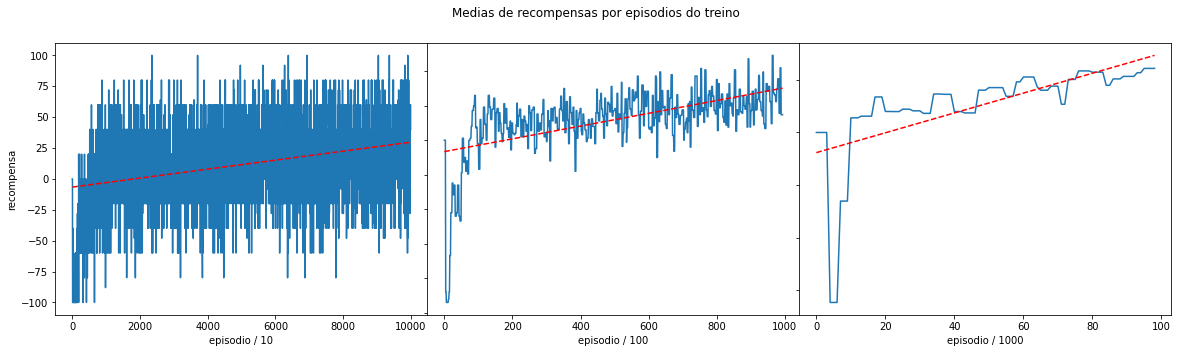

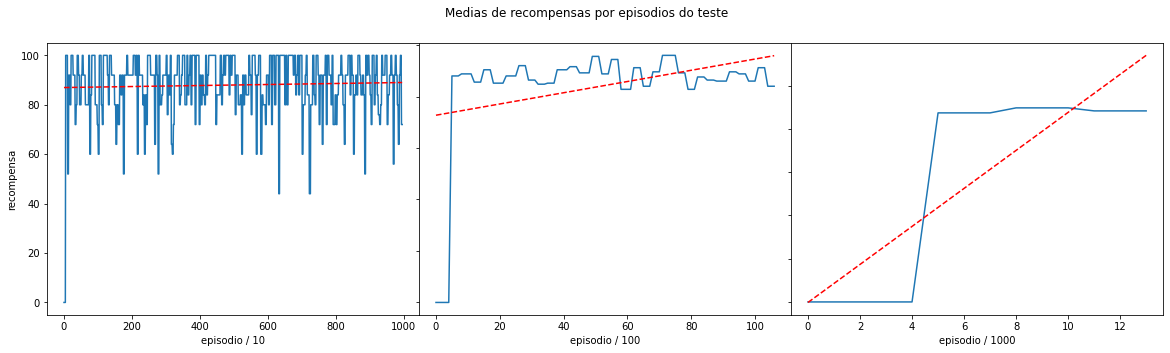

In [19]:
divisores = [10, 100, 1000]
dict_recompensas = [[historia_treino, 'treino'], [historia_teste, 'teste']]
for dict_recompensa in dict_recompensas:
    hist_recompensa = dict_recompensa[0]
    tipo = dict_recompensa[1]
    fig, axs = plt.subplots(1, 3, gridspec_kw={'wspace': 0}, figsize=(20,5))
    fig.suptitle('Medias de recompensas por episodios do {}'.format(tipo))
    axs[0].set(ylabel='recompensa')
    grafico = 0
    for divisor in divisores:
        recompensas = []
        recompensas_media = []
        recompensas_ref = []
        ref = 0
        for i in range(len(hist_recompensa) + 1):
            if len(recompensas) % divisor == 0:
                recompensas_media.append( sum(recompensas[-divisor:]) / divisor )
            if len(hist_recompensa) == i or hist_recompensa[i]['episode'] != ref:
                recompensas.append( round(sum(recompensas_ref), 1) )
                ref += 1
                recompensas_ref = []
            if len(hist_recompensa) != i:
                recompensas_ref.append( hist_recompensa[i]['reward'] )

        #plota grafico
        x_plot = np.arange(len(recompensas_media))
        axs[grafico].set(xlabel='episodio / {}'.format(divisor))
        axs[grafico].plot(x_plot, recompensas_media)
        #linha de tendencia
        z = np.polyfit(x_plot, recompensas_media, 1)
        p = np.poly1d(z)
        axs[grafico].plot(x_plot, p(x_plot),"r--")
        axs[grafico].label_outer()
        grafico += 1

        fig.savefig('result_{}.png'.format(tipo), bbox_inches='tight') #salva o grafico em uma foto

###Jogando contra o agente treinado.

In [12]:
def jogada_agente(agente, estado):
    estado_reshape = [estado]
    saida = agente.compute_q_values( estado_reshape )
    jogada = np.argmax( saida )
    return jogada

def printa_campo(estado, simbolo_jogador):
    for i in range(len(estado)):
        if( i ) % 3 == 0:
            print()
        else:
            print('| ', end='')
        simbolo_maquina = 'O'
        if simbolo_jogador == 'O':
            simbolo_maquina = 'X'
        if estado[i] == -1:
            print(simbolo_jogador + ' ', end='')
        elif estado[i] == 1:
            print(simbolo_maquina + ' ', end='')
        else:
            print('- ', end='')
    print()

#jogar contra a maquina
ambiente = JogoDaVelhaEnv( teste=True ) #cria o ambiente para o jogo
agente = DQNAgent( model=modelo, policy=GreedyQPolicy(), nb_actions=n_acoes, memory=memoria )
agente.compile(optimizers.Adam())
agente.load_weights('dqn.h5f')

vez_do_jogador = False
acabou = False
simbolo_jogador = 'X'

while not acabou:
    if vez_do_jogador:
        #jogada do jogador
        jogada_valida = False
        while not jogada_valida:
            jogada = int(input('campo a jogar: '))
            if ambiente.campo[ jogada ] != 0:
                print('campo inválido')
            else:
                ambiente.campo[ jogada ] = -1
                jogada_valida = True
                acabou, resultado = ambiente.acabou()

    else:
        #jogada da maquina
        jogada_valida = False
        jogada = jogada_agente( agente, ambiente.observacao() )
        if ambiente.campo[ jogada ] == 0:
            ambiente.campo[ jogada ] = 1
            acabou, resultado = ambiente.acabou()
        else:
            print('jogada invalida da IA')
            acabou = True
            resultado = -1
    
    vez_do_jogador = not vez_do_jogador
    printa_campo( ambiente.observacao(), simbolo_jogador )

ganhador = None #define uma variavel para quem ganhou o jogo
if resultado == -1: #se o resultado for 1
    ganhador = 'Voce ganhou' #o ganhador foi a IA
elif resultado == 1: #se o resultado for -1
    ganhador = 'A IA ganhou' #o ganhador foi o oponente aleatorio
else: #se o resultado for 0
    ganhador = 'Deu velha' #o jogo deu velha

print(ganhador)


- | - | - 
- | - | - 
O | - | - 
campo a jogar: 4

- | - | - 
- | X | - 
O | - | - 
jogada invalida da IA

- | - | - 
- | X | - 
O | - | - 
Voce ganhou


In [10]:
def jogada_agente(agente, estado):
    estado_reshape = [estado]
    saida = agente.compute_q_values( estado_reshape )
    jogada = np.argmax( saida )
    return jogada

ambiente = JogoDaVelhaEnv( teste=True ) #cria o ambiente para o jogo
agente = DQNAgent( model=modelo, policy=GreedyQPolicy(), nb_actions=n_acoes, memory=memoria )
agente.compile(optimizers.Adam())
agente.load_weights('dqn.h5f')

ambiente.campo[0] = -1
ambiente.campo[6] = 1
jogada = jogada_agente( agente, ambiente.observacao() )

print(jogada)

0
